### Initial setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import logging
import math
import os
import pathlib
import pickle
from collections import defaultdict
from typing import Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing

In [4]:
import dojolib
from datastore import DataStore

In [5]:
logging.basicConfig(level=logging.INFO)

### Plot functions

In [6]:
def rmse_single_transfer(
    trainsz2rmses_single: dict[int, list[float]],
    trainsz2rmses_xfer: dict[int, list[float]],
    outdir: pathlib.Path,
    output_prefix: str,
):
    logging.getLogger('matplotlib').setLevel(logging.WARNING)

    xs = sorted(int(t) for t in trainsz2rmses_single.keys())
    ys = list(np.mean(trainsz2rmses_single[x]) for x in xs)
    ydevs = list(np.std(trainsz2rmses_single[x]) for x in xs)
    ytop = max(ys)
    plt.figure(figsize=(12, 6))
    plt.plot(xs, ys, marker='o', label="Single-user")
    plt.fill_between(
        xs,
        np.array(ys) - np.array(ydevs),
        np.array(ys) + np.array(ydevs),
        alpha=0.2,
    )

    xs = sorted(int(t) for t in trainsz2rmses_xfer.keys())
    ys = list(np.mean(trainsz2rmses_xfer[x]) for x in xs)
    ydevs = list(np.std(trainsz2rmses_xfer[x]) for x in xs)
    plt.plot(xs, ys, marker='o', label="Cross-training")
    plt.fill_between(
        xs,
        np.array(ys) - np.array(ydevs),
        np.array(ys) + np.array(ydevs),
        alpha=0.2,
    )
    ytop = max(max(ys), ytop)

    xlabel = "Número de Análises Utilizadas para Treino"
    os.makedirs(outdir, exist_ok=True)

    # plt.xticks(splits, x_ticks, fontsize=20)
    plt.xticks(xs, [str(int(x)) for x in xs], fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("RMSE Médio", fontsize=20)
    plt.ylim(bottom=0, top=math.ceil(ytop))
    plt.legend(fontsize=20, bbox_to_anchor=(1, 1.034))
    plt.grid(True)
    plt.tick_params(axis="both", which="major", labelsize=20)

    plt.tight_layout()
    output = os.path.join(outdir, f'{output_prefix}_2x1.pdf')
    plt.savefig(output, format='pdf')
    output = os.path.join(outdir, f'{output_prefix}_2x1.png')
    plt.savefig(output, format='png')

In [7]:
def plot_feat_importance(
    feat2imps_single: dict[str, list[float]],
    outdir: pathlib.Path,
    output_prefix: str,
):
    plt.figure(figsize=(12, 6))
    xs, ys = list(feat2imps_single.keys()), list(feat2imps_single.values())
    ys = list(np.mean(imps) for imps in ys)
    ystotal = sum(ys)
    ys = list(y/ystotal for y in ys)
    assert abs(sum(ys) - 1) < 1e-4

    xs = [dojolib.FEATURE_NAMES.get(x, x) for x in xs]

    # Sort features by importance
    sorted_indices = np.argsort(ys)[::]
    xs = [xs[i] for i in sorted_indices]
    ys = [ys[i] for i in sorted_indices]
    # Show the top 8 most important features and aggregate the remaining ones into "Others"
    top_n = 8
    sorted_indices = np.argsort(ys)[::]
    xs = [xs[i] for i in sorted_indices]
    ys = [ys[i] for i in sorted_indices]
    others_ys = ys[:-top_n]
    xs = xs[-top_n:]
    ys = ys[-top_n:]
    xs.insert(0, "Others")
    ys.insert(0, sum(others_ys))

    os.makedirs(outdir, exist_ok=True)
    plt.xlabel("Importância da Feature", fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.barh(xs, ys)
    plt.tight_layout()
    output = os.path.join(outdir, f'{output_prefix}_2x1.pdf')
    plt.savefig(output, format='pdf')
    output = os.path.join(outdir, f'{output_prefix}_2x1.png')
    plt.savefig(output, format='png')

# Notes on architecture

* `datastore.py` is shared with `django-DefectDojo/dojo/crivo`; this file loads `cve2meta.pkl`, which is built from the data downloaded by the `crivo-init` container.
* `dojolib.py` contains auxiliary classes and functions to help process Dojo data and train the model. `common.py` is the old library used primarily by Shogun (our system to manage Shodan vulnerabilities).

In [8]:
# output_data is at pugna:~cunha/git/network-security/vulnrank/data
DATADIR = pathlib.Path("data")
# metadata is at pugna:~cunha/git/network-security/vulnrank/data/cve-metadata/
CVE2META_PICKLE_FP = DATADIR / pathlib.Path("cve-metadata/cve2meta.pkl.gz")
GRAPHS_OUTDIR = pathlib.Path("report_graphs")

In [9]:
ds = DataStore()
ds.load(metadata_fp=CVE2META_PICKLE_FP)
# cve2meta = ds.get_data()

In [10]:
# FRACTIONS = [0.25,0.5,0.75]
# ITERATIONS = 5
FRACTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ITERATIONS = 10
def process_user(user, df: pd.DataFrame):
    trainsz2rmses_single: dict[int, list[float]] = {}
    trainsz2rmses_xfer: dict[int, list[float]] = {}
    feat2imps_single = {}  # get last one

    for frac in FRACTIONS:
        logging.info("processing frac %f, user %s", frac, user)
        trainsz, rmses_single, feat2imps_single = dojolib.compute_model_accuracy(
            df,
            frac,
            user,
            transfer_learning=False,
            num_estimators=200,
            learning_rate=0.15,
            iterations=ITERATIONS,
        )
        trainsz2rmses_single[trainsz] = rmses_single

        trainsz2, rmses_xfer, _feat2imps_xfer = dojolib.compute_model_accuracy(
            df,
            frac,
            user,
            transfer_learning=True,
            num_estimators=200,
            learning_rate=0.15,
            iterations=ITERATIONS,
        )
        trainsz2rmses_xfer[trainsz] = rmses_xfer

        assert trainsz == trainsz2

    return user, trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single

In [ ]:
exp_outdir = GRAPHS_OUTDIR / "class"
os.makedirs(exp_outdir, exist_ok=True)

num_features, num_rankings = dojolib.load_features_rankings(DATADIR, "joined_class", ds)
num_df = dojolib.get_merged_df(num_features, num_rankings)
users = list(i for i in num_df["email"].unique())

num_user2data = {}
for user in users:
    user, trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single = process_user(user, num_df)
    num_user2data[user] = (trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single)
    with open(exp_outdir/f"user2data_{user}.pickle", "wb") as fd:
        pickle.dump((trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single), fd)
    # trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single = num_user2data[user]
    rmse_single_transfer(
        trainsz2rmses_single,
        trainsz2rmses_xfer,
        exp_outdir,
        f"rmse_user_{user}",
    )
    plot_feat_importance(
        feat2imps_single,
        exp_outdir,
        f"feat_importance_user_{user}",
    )

In [ ]:
exp_outdir = GRAPHS_OUTDIR/"crivo_num"
os.makedirs(exp_outdir, exist_ok=True)

crivo_num_features, crivo_num_rankings = dojolib.load_features_rankings(DATADIR, "crivo_num", ds)
crivo_num_df = dojolib.get_merged_df(crivo_num_features, crivo_num_rankings)
users = list(i for i in crivo_num_df["email"].unique())

crivo_num_user2data = {}
for user in users:
    if len(crivo_num_df[crivo_num_df["email"] == user]) < 12:
        logging.warning("user %s has less than 12, skipping", user)
        continue
    (
        user,
        trainsz2rmses_single,
        trainsz2rmses_xfer,
        feat2imps_single,
    ) = process_user(user, crivo_num_df)
    crivo_num_user2data[user] = (trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single)
    with open(exp_outdir/f"user2data_{user}.pickle", "wb") as fd:
        pickle.dump((trainsz2rmses_single, trainsz2rmses_xfer, feat2imps_single), fd)
    rmse_single_transfer(
        trainsz2rmses_single,
        trainsz2rmses_xfer,
        exp_outdir,
        f"rmse_user_{user}",
    )
    plot_feat_importance(
        feat2imps_single,
        exp_outdir,
        f"feat_importance_user_{user}",
    )

### RMSE graph single + transfer for each user

### Feature Importance Graph

### RMSE line Graphic for each User

{"5": {"16": [1.142949879483301, 1.0558798317095204, 1.2703388057089051, 1.142949879483301, 1.0558798317095204, 1.2703388057089051, 1.142949879483301, 1.0558798317095204, 1.2703388057089051, 1.142949879483301, 1.0558798317095204, 1.2703388057089051], "17": [1.5720805486327176, 1.440731008343482, 1.3538197651028225, 1.5720805486327176, 1.440731008343482, 1.3538197651028225, 1.5720805486327176, 1.440731008343482, 1.3538197651028225, 1.5720805486327176, 1.440731008343482, 1.3538197651028225], "18": [1.3151762477155575, 1.3820976112656793, 1.8182538314277585, 1.3151762477155575, 1.3820976112656793, 1.8182538314277585, 1.3151762477155575, 1.3820976112656793, 1.8182538314277585, 1.3151762477155575, 1.3820976112656793, 1.8182538314277585], "20": [1.2399778718363281, 1.2524539336055487, 1.5561023244151588, 1.2399778718363281, 1.2524539336055487, 1.5561023244151588, 1.2399778718363281, 1.2524539336055487, 1.5561023244151588, 1.2399778718363281, 1.2524539336055487, 1.5561023244151588], "19": [0.

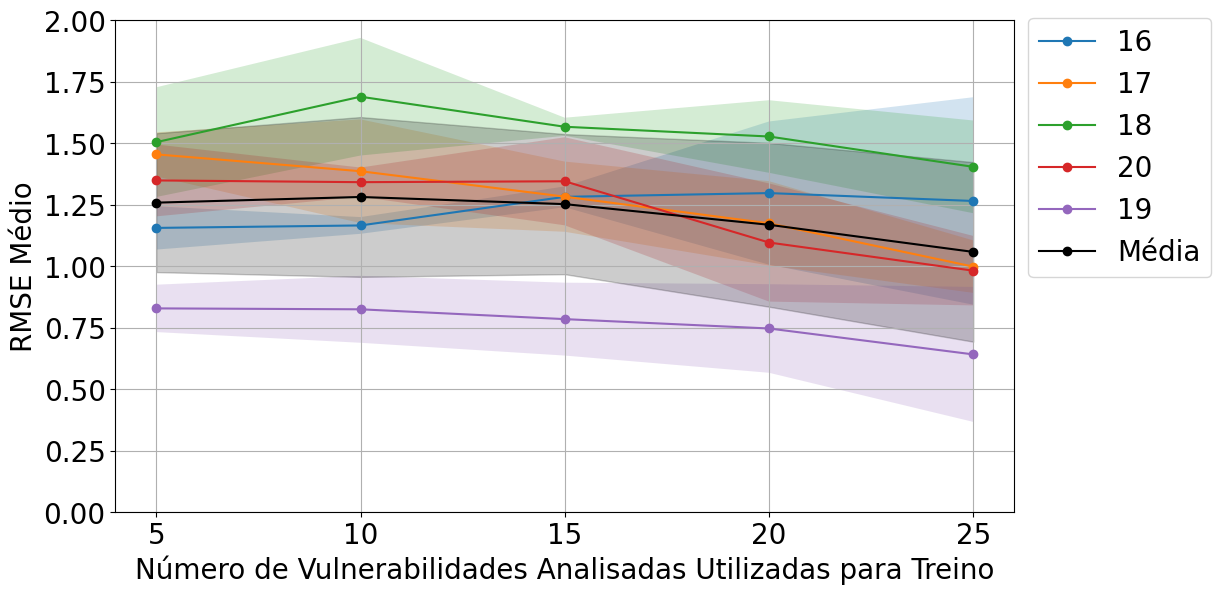

In [ ]:
def rmseLineGraphic(
    split2user2rmse: dict,
    users: Optional[list] = None,
    absolute=False,
    plot_average=False,
):
    logging.getLogger('matplotlib').setLevel(logging.WARNING)
    plt.figure(figsize=(12, 6))

    if users is None:
        users = list(next(iter(split2user2rmse.values())).keys())

    ytop = 0

    splits = list(split2user2rmse.keys())
    user2rmselist = defaultdict(list)
    for split, user2rmse in split2user2rmse.items():
        for user in users:
            user2rmselist[user].append(user2rmse[user])

    for user in users:
        rmselist = user2rmselist[user]
        values = list(np.mean(rmse) for rmse in rmselist)
        stddevs = list(np.std(rmse) for rmse in rmselist)
        ytop = max(max(values), ytop)

        plt.plot(splits, values, marker='o', label=str(user))
        plt.fill_between(
            splits,
            np.array(values) - np.array(stddevs),
            np.array(values) + np.array(stddevs),
            alpha=0.2,
        )

    if plot_average:
        rmselist_global = [list() for _ in range(len(splits))]
        for _user, rmselist in user2rmselist.items():
            print(_user)
            for i, rmse in enumerate(rmselist):
                print(i, rmse)
                rmselist_global[i].extend(rmse)

        print(rmselist_global)

        values = list(np.mean(rmse) for rmse in rmselist_global)
        stddevs = list(np.std(rmse) for rmse in rmselist_global)
        ytop = max(max(values), ytop)

        plt.plot(splits, values, marker='o', label="Média", color='black')
        plt.fill_between(
            splits,
            np.array(values) - np.array(stddevs),
            np.array(values) + np.array(stddevs),
            alpha=0.2,
            color='black',
        )

    if not absolute:
        x_ticks = ["10/90", "20/80", "30/70", "40/60", "50/50", "60/40", "70/30", "80/20", "90/10"]
        x_label = "% da Base Utilizada para Treino"
        output_name = 'rmse_relative'
    else:
        x_ticks = [str(s) for s in splits]
        x_label = "Número de Vulnerabilidades Analisadas Utilizadas para Treino"
        output_name = 'rmse_absolute'

    plt.xticks(splits, x_ticks, fontsize=20)
    plt.xlabel(x_label, fontsize=20)
    plt.ylabel("RMSE Médio", fontsize=20)
    plt.ylim(bottom=0, top=math.ceil(ytop))
    plt.tight_layout()
    plt.legend(fontsize=20, bbox_to_anchor=(1, 1.034))
    plt.grid(True)
    plt.tight_layout()
    plt.tick_params(axis="both", which="major", labelsize=20)
    output = os.path.join('model_graphics/', f'{output_name}.pdf')
    plt.savefig(output, format='pdf')

rmseLineGraphic(split2user2rmses, absolute=True, plot_average=True)
# rmseLineGraphic(average_rmse_dict_percent, users, splits_percent, False)

In [ ]:

    crivo_num_df = get_merged_df(crivo_num_features, crivo_num_rankings)
    users = list(int(i) for i in crivo_num_df["user_id"].unique())


### Model Training with split of Absolute Values ​​and Percentages

In [96]:
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np

NUM_SEEDS = 3
NUM_ESTIMATORS = 100
MAX_DEPTH = 10
LEARNING_RATE = 0.2

def training_model_abs_split(
    splits: list,
    users: list,
    features_df: pd.DataFrame,
    absolute=False,
) -> dict[int | float, dict[str | int, list[float]]]:
    split2user2rmses = defaultdict(dict)
    for split in splits:
        for user in users:
            user_accuracies = []
            user_data = features_df[features_df["username"] == user]
            print(f"Processing user: {user} with {len(user_data)} samples. Split {split}.")
            if len(user_data) < 10:
                print(f"Skipping user: {user} due to insufficient data.")
                continue
            if absolute and split >= len(user_data):
                print(f"Skipping user: {user} due to insufficient data for split {split}.")
                continue
            elif not absolute and split*len(user_data) < 3:
                print(f"Skipping user: {user} due to insufficient data for split {split}.")
                continue

            for iteration in range(NUM_SEEDS):
                seed = iteration + 32

                x = user_data.drop(columns=["username", "vote"])
                y = user_data["vote"]

                test_size = int(len(user_data) - split) if absolute else float(1 - split)
                x_train, x_test, y_train, y_test = train_test_split(
                    x, y, test_size=test_size, random_state=seed, shuffle=True
                )

                model = XGBRegressor(
                    n_estimators=NUM_ESTIMATORS,
                    learning_rate=LEARNING_RATE,
                    max_depth=MAX_DEPTH,
                    verbosity=0,
                    enable_categorical=True,
                    random_state=seed,
                )
                model.fit(x_train, y_train)

                y_pred = model.predict(x_test)

                # y_test_list = y_test.to_list()
                # y_pred_7 = []
                # y_test_7 = []

                # for index, item in enumerate(y_pred):
                #     if item >= 7: # valores maiores que 7 (vulnerabilidades mais importantes)
                #         y_pred_7.append(y_pred[index])
                #         y_test_7.append(y_test_list[index])

                # if len(y_pred_7) == 0:
                #     continue
                #mse = mean_squared_error(y_test_7, y_pred_7) # para valores maiores que 7

                rmse = root_mean_squared_error(y_test, y_pred)
                user_accuracies.append(rmse)

            split2user2rmses[split][user] = user_accuracies

    return split2user2rmses

splits_percent = [value / 10 for value in range(1, 10)] # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
splits_int = [value for value in range(5, 26, 5)] # [5, 10, 15, 20, 25]

# average_rmse_dict_abs = training_model(splits_int, users, df_drop, True)
# average_rmse_dict_percent = training_model(splits_percent, users, df_drop, False)
# average_rmse_dict_abs = training_model(splits_int, [17], df_drop, False)
split2user2rmses = training_model_abs_split(splits_int, users, df_drop, True)
# average_rmse_dict_percent = training_model(splits_percent, [17], df_drop, False)

Processing user: 16 with 31 samples. Split 5.
Processing user: 17 with 41 samples. Split 5.
Processing user: 18 with 31 samples. Split 5.
Processing user: 20 with 31 samples. Split 5.
Processing user: 19 with 31 samples. Split 5.
Processing user: 16 with 31 samples. Split 10.
Processing user: 17 with 41 samples. Split 10.
Processing user: 18 with 31 samples. Split 10.
Processing user: 20 with 31 samples. Split 10.
Processing user: 19 with 31 samples. Split 10.
Processing user: 16 with 31 samples. Split 15.
Processing user: 17 with 41 samples. Split 15.
Processing user: 18 with 31 samples. Split 15.
Processing user: 20 with 31 samples. Split 15.
Processing user: 19 with 31 samples. Split 15.
Processing user: 16 with 31 samples. Split 20.
Processing user: 17 with 41 samples. Split 20.
Processing user: 18 with 31 samples. Split 20.
Processing user: 20 with 31 samples. Split 20.
Processing user: 19 with 31 samples. Split 20.
Processing user: 16 with 31 samples. Split 25.
Processing user: 1

RMSE: 0.9710


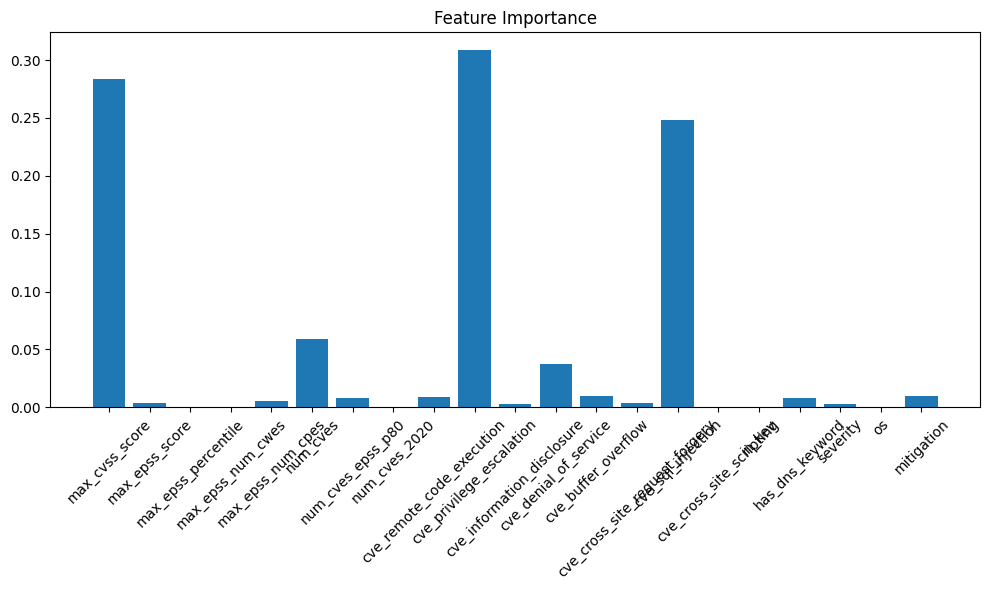

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Convert columns to categorical
cat_cols = ['in_kev', 'has_dns_keyword', 'severity', 'os', 'mitigation']
for col in cat_cols:
    df_drop[col] = df_drop[col].astype('category')

# Split data
x = df_drop.drop(columns=['vote_class'])  # replace 'target' with your target column
y = df_drop['vote_class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) #, random_state=42)

# Train XGBoost regressor
model = XGBRegressor(enable_categorical=True) #, random_state=42)
model.fit(x_train, y_train)

# Evaluate accuracy
y_pred = model.predict(x_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(x_train.columns, model.feature_importances_)
plt.xticks(rotation=45)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
df_os = crivo_num_df[crivo_num_df['title'].apply(lambda x: 'Operating System (OS) End of Life (EOL) Detection' in str(x))]
df_keyex = crivo_num_df[crivo_num_df['title'].apply(lambda x: 'Weak Key Exchange (KEX) Algorithm(s) Supported (SSH)' in str(x))]
df_weakalgo = crivo_num_df[crivo_num_df['title'].apply(lambda x: 'Weak Host Key Algorithm(s) (SSH)' in str(x))]

df_merged = pd.concat([df_os, df_keyex, df_weakalgo], ignore_index=True)

NameError: name 'df' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [ ]:
le = LabelEncoder()
crivo_num_df['vote_class_encoded'] = le.fit_transform(crivo_num_df['vote_class'].astype(str))

# Converter colunas categóricas para tipo 'category'
crivo_num_df['vuln_id_from_tool'] = crivo_num_df['vuln_id_from_tool'].astype('category')
crivo_num_df['mitigation'] = crivo_num_df['mitigation'].astype('category')

# Separar features e target
x = crivo_num_df.drop(columns=['vote_class', 'vote_class_encoded'])
y = crivo_num_df['vote_class_encoded']

In [ ]:
mask_train = crivo_num_df['vote_class'].notna()
x_train, y_train = x[mask_train], y[mask_train]

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', enable_categorical=True)
model.fit(x_train, y_train)

/home/thiagohbs/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:24:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
mask_pred = crivo_num_df['vote_class'].isna()
crivo_num_df.loc[mask_pred, 'vote_class_encoded'] = model.predict(x[mask_pred])

In [ ]:
crivo_num_df['vote_class_predicted'] = le.inverse_transform(crivo_num_df['vote_class_encoded'].astype(int))

In [ ]:
df_resultado = pd.concat([df_merged, crivo_num_df], axis=1)
df_final = df_resultado[['title', 'vote_class', 'vote_class_predicted']]


In [ ]:
df_final

,title,vote_class,vote_class,vote_class_predicted
0,Operating System (OS) End of Life (EOL) Detect...,NaN,NaN,Critical
1,Operating System (OS) End of Life (EOL) Detect...,NaN,NaN,Critical
2,Operating System (OS) End of Life (EOL) Detect...,NaN,NaN,Critical
3,Operating System (OS) End of Life (EOL) Detect...,NaN,NaN,Critical
4,Operating System (OS) End of Life (EOL) Detect...,Critical,Critical,Critical
5,Operating System (OS) End of Life (EOL) Detect...,Critical,Critical,Critical
6,Operating System (OS) End of Life (EOL) Detect...,Critical,Critical,Critical
7,Operating System (OS) End of Life (EOL) Detect...,Critical,Critical,Critical
8,Operating System (OS) End of Life (EOL) Detect...,NaN,NaN,Critical
9,Operating System (OS) End of Life (EOL) Detect...,Critical,Critical,Critical


In [ ]:
def get_cvelist(text):
    pattern = r"^\*\*CVEs\*\*: (.*)$"
    match = re.search(pattern, text, re.MULTILINE)
    if match:
        cve_list = match.group(1).split(', ')
        if cve_list == ['']:
            return None
        else:
            return list(set(cve_list))
    else:
        return None

def num_cves(cve_list):
    if cve_list is None:
        return 0
    else:
        return len(cve_list)

def process_cve_list(cve_list, cve_dataset):
    if cve_list is None:
        return {
            'cvss_score': 0,
            'epss_score': 0,
            'epss_percentile': 0,
            'num_cves': 0,
            'num_cves_epss80': 0,
            'num_cves_epss2020': 0,
            'num_cwes': 0,
            'num_cpes': 0,
            'in_kev': False,
            'remote_code_execution': 0,
            'privilege_escalation': 0,
            'information_disclosure': 0,
            'denial_of_service': 0,
            'buffer_overflow': 0,
            'cross_site_request_forgery': 0,
            'sql_injection': 0,
            'cross_site_scripting': 0
        }

    cvss_score = 0
    epss_score = 0
    epss_percentile = 0
    num_cves = len(cve_list)
    num_cves_epss80 = 0
    num_cves_epss2020 = 0
    num_cwes = 0
    num_cpes = 0
    in_kev = False
    classification = None

    for cve in cve_list:
        cve = cve.lower()
        impact = cve_dataset.get(cve, {}).get('impact', {})
        epss = cve_dataset.get(cve, {}).get('epss', {})
        cwes = cve_dataset.get(cve, {}).get('cwes', [])
        cpes = cve_dataset.get(cve, {}).get('cpes', [])
        classification_data = cve_dataset.get(cve, {}).get('classification', {})

        cvss_score_candidate = impact.get('cvss_score', 0)
        epss_score_candidate = epss.get('epss_score', 0)

        year = int(cve.split('-')[1])
        if year >= 2020:
            num_cves_epss2020 += 1
        if epss.get('epss_percentile', 0) >= 0.8:
            num_cves_epss80 += 1
        in_kev = max(in_kev, 'kev' in cve_dataset.get(cve, {}))

        if cvss_score < cvss_score_candidate:
            cvss_score = cvss_score_candidate

        if epss_score < epss_score_candidate:
            epss_score = epss_score_candidate
            epss_percentile = epss.get('epss_percentile', 0)
            num_cwes = len(set(cwes))
            num_cpes = len(set(cpes))
            classification = classification_data

        remote_code_execution = classification.get('remote code execution', 0)
        privilege_escalation = classification.get('privilege escalation', 0)
        information_disclosure = classification.get('information disclosure', 0)
        denial_of_service = classification.get('denial of service', 0)
        buffer_overflow = classification.get('buffer overflow', 0)
        cross_site_request_forgery = classification.get('cross site request forgery', 0)
        sql_injection = classification.get('sql injection', 0)
        cross_site_scripting = classification.get('cross site scripting', 0)

    return {
        'cvss_score': cvss_score,
        'epss_score': epss_score,
        'epss_percentile': epss_percentile,
        'num_cves': num_cves,
        'num_cves_epss80': num_cves_epss80,
        'num_cves_epss2020': num_cves_epss2020,
        'num_cwes': num_cwes,
        'num_cpes': num_cpes,
        'in_kev': in_kev,
        'remote_code_execution': remote_code_execution,
        'privilege_escalation': privilege_escalation,
        'information_disclosure': information_disclosure,
        'denial_of_service': denial_of_service,
        'buffer_overflow': buffer_overflow,
        'cross_site_request_forgery': cross_site_request_forgery,
        'sql_injection': sql_injection,
        'cross_site_scripting': cross_site_scripting
    }

def merge_features(df, cve_dataset):
    df_updates = df['cve_list'].apply(lambda cves: pd.Series(process_cve_list(cves, cve_dataset)))
    df[df_updates.columns] = df_updates

    df_updates = df['description'].apply(lambda desc: pd.Series(set_dns_keyword(desc)))
    df[df_updates.columns] = df_updates
    return df

def merge_tables(df_features, df_votes):
    df = pd.merge(df_features, df_votes, left_on='id', right_on='id', how='left')
    return df

def get_cvelist(text):
    pattern = r"^\*\*CVEs\*\*: (.*)$"
    match = re.search(pattern, text, re.MULTILINE)
    if match:
        cve_list = match.group(1).split(', ')
        if cve_list == ['']:
            return None
        else:
            return list(set(cve_list))
    else:
        return None

def set_mitigation(text):
    pattern = '\n'
    mitigation = text.split(pattern)[0]
    return mitigation


OS_MAP = {
    "canonical": "linux",
    "centos": "linux",
    "debian": "linux",
    "linux": "linux",
    "microsoft": "windows",
    "redhat": "linux",
    "ubuntu": "linux",
    None: "unknown",
}
import re
OS_REGEX = re.compile(r"\*\*OS\*\*: cpe:/o:([^:]+):.*")
def set_operating_system(desc):
    return OS_MAP.get(
        next((OS_REGEX.match(line).group(1) for line in desc.split("\n") if OS_REGEX.match(line)), None), "other"
    )
HOSTNAME_REGEX = re.compile(r"^\*\*Hostname\*\*: (.*)$")
